<a href="https://colab.research.google.com/github/ozkanyildirim/Sentiment_Analaysis_in_Spark/blob/main/ESPRIT_sentiment_analysis_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-06-30 06:56:11--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-06-30 06:56:12--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-06-30 06:56:12 (33.6 MB/s) - written to stdout [1608/1608]

setup Cola

# Sentiment Analysis ESPRIT

Project Goal: Our goal is to build models with high accuracy to make correct predictions regarding given customer comments, whether they are positive or negative.

Data: **train data product reviews.csv** and **test data product reviews.csv** text data consisting of comments and bicathegorical labels.

Table of contents

1. Exploratory Data Analaysis (Preparing Train and Test Data)
> I. Initials <br> 
> II. Data Preparation <br> 
> III. Data Visualisation <br> 
2. Sentiment Analysis
> I. Logistic Regression and Naive Bayes with CountVectorizer <br> 
> II. Logistic Regression and Naive Bayes with TFIDF<br> 
> III. Universal Sentence Encoder <br> 

3. Conclusion












## 1. Exploratory Data Analysis (Preparing Train and Test Data)

> ### I.  Initials

>> a. Importing Initial Modules

In [22]:
# general purpose modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# pyspark modules
import pyspark
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer

# spark nlp modules
import sparknlp



>> b.  Starting a Pyspark Session

In [3]:
spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  3.1.1
Apache Spark version:  3.0.3


> ### II.  Data Preparation

>> a.  Retrieving Train Data

In [4]:
comments_train = spark.read.options(delimiter=';').csv('train data product reviews.csv', inferSchema=True, header=True)
comments_train.show(truncate=True, n=5)
comments_train.count(), comments_train.select('label').distinct().count()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    0|"Reference Yes, L...|
|    0|NO!!!!!!I will gi...|
|    0|Neat Features/Unc...|
|    1|"Progressive-Unde...|
|    0|"The theif who st...|
+-----+--------------------+
only showing top 5 rows



(51979, 2)

In 'label' column we have 0's and 1's only. Let's rearrange this data frame as *df_train*.

In [5]:
df_train = comments_train.select('text', 'label')
df_train.show(truncate=True, n=5)
df_train.groupBy('label').count().show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|"Reference Yes, L...|    0|
|NO!!!!!!I will gi...|    0|
|Neat Features/Unc...|    0|
|"Progressive-Unde...|    1|
|"The theif who st...|    0|
+--------------------+-----+
only showing top 5 rows

+-----+-----+
|label|count|
+-----+-----+
|    1|37294|
|    0|14685|
+-----+-----+



In [6]:
df_train.describe().show()

+-------+--------------------+------------------+
|summary|                text|             label|
+-------+--------------------+------------------+
|  count|               51979|             51979|
|   mean|                 1.0|0.7174820600627176|
| stddev|                 NaN|0.4502282235795239|
|    min|!!!!!: the song B...|                 0|
|    max|ƒ∞t is cheap tabl...|                 1|
+-------+--------------------+------------------+



In [7]:
def balance_check(df, col='label'):
  """
  Checks the balance of data regarding labels and displays.
  df: data frame
  col: string column
  """
  positive = df.where(df.label == '1').count()
  negative = df.where(df.label == '0').count()
  pos_percent = 100 * positive/(positive + negative)
  neg_percent = 100 * negative/(positive + negative)
  print(f'Positive Comments: {positive} which is %{pos_percent}')
  print(f'Negative Comments: {negative} which is %{neg_percent}')

balance_check(df_train)

Positive Comments: 37294 which is %71.74820600627176
Negative Comments: 14685 which is %28.251793993728235


Given the distribution of the comments in training data we have a relative unbalanced data (~ 0.28 - 0.72). Before deciding whether applying a downsizing or upsizing technique, let's first check whether do we have duplications in the training data.

In [8]:
import pyspark.sql.functions as funcs
df_train.groupBy(df_train.text)\
    .count()\
    .where(funcs.col('count') > 1)\
    .select(funcs.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|     14143|
+----------+



Let's drop the duplicated rows and keep only the first occurences.

In [9]:
df_train = df_train.dropDuplicates((['text']))
balance_check(df_train)

Positive Comments: 29454 which is %67.19441529406397
Negative Comments: 14380 which is %32.805584705936035


After removing the duplications, the distribution of comments in the training data changed slightly to the positive (more balanced ~ 0.33 - 0.67). For now, we keep the data in this distribution and do not apply any downsizing or upsizing technique (or generation), but we use the F1 score as a performance metric to avoid being biased by the data distribution.

Now we are going to maintain a *df_test* similar to *df_train*.

>> b.  Retrieving Test Data

In [10]:
comments_test = spark.read.options(delimiter=';').csv('test data product reviews.csv', inferSchema=True, header=True)
comments_test.show(truncate=True, n=5)
comments_test.count()

+--------------------+
|          label,text|
+--------------------+
|0,Not worth the m...|
|"0,""I changed my...|
|"0,""How quickly ...|
|0,DOA Did Not Pow...|
|"0,""support: I o...|
+--------------------+
only showing top 5 rows



11703

We are going to use *regex* to describe patters to obtain a clean data frame with columns text and label.

In [11]:
regex_pattern = r'"*([01])(.+)'
comments_test = comments_test.withColumn('text', regexp_extract(col('label,text'), regex_pattern, 2))\
                 .withColumn('label', regexp_extract(col('label,text'), regex_pattern, 1))
df_test = comments_test.select('text', 'label')
df_test.show(truncate=True, n=5)
df_test.count(), df_test.select('label').distinct().count()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|,Not worth the mo...|    0|
|,""I changed my m...|    0|
|,""How quickly we...|    0|
|,DOA Did Not Powe...|    0|
|,""support: I ord...|    0|
+--------------------+-----+
only showing top 5 rows



(11703, 2)

In [12]:
import pyspark.sql.functions as funcs
df_test.groupBy(df_test.text)\
    .count()\
    .where(funcs.col('count') > 1)\
    .select(funcs.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [13]:
balance_check(df_test)

Positive Comments: 5819 which is %49.72229342903529
Negative Comments: 5884 which is %50.27770657096471


Apparently we do not have duplications in test data. And our test data is balanced.

Now that we have both *df_train* and *df_test* in our targetted composition, we can progress with data visualisation and finally the **Sentiment Analysis**.

> ### III. Data Visualisation

In [14]:
import plotly.express as px

In [15]:
df_viz_train = df_train.toPandas()
df_viz_train.to_csv('train_viz', sep='\t', encoding='utf-8', index=False)
df_viz_test = df_train.toPandas()
df_viz_test.to_csv('test_viz', sep='\t', encoding='utf-8', index=False)

In [16]:
# length of comment
df_viz_train['length'] = df_viz_train.text.apply(lambda x: len(x))
df_viz_train.head()
df_viz_test['length'] = df_viz_test.text.apply(lambda x: len(x))
df_viz_train.head()

,text,label,length
0,This is a horrible clock!: I had this clock fo...,0,322
1,Roll On Texas Moon: I especially like Roy Roge...,1,451
2,A total waste: My cat's been on this spot for ...,0,234
3,On site image does not match figure: I'm a tad...,0,280
4,Should be made into a movie.: In this action a...,1,310


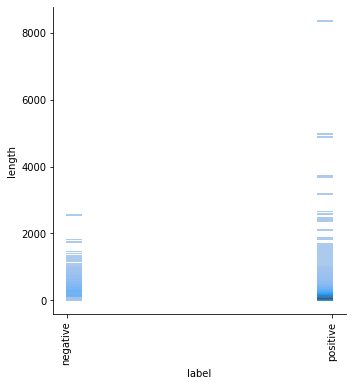

In [17]:
sns.displot(data=df_viz_train, x='label', y='length')
plt.xticks([0,1], ['negative', 'positive'], rotation='vertical')
plt.show()

In [45]:
def clean_token_extractor(df):

    '''
    Returns three pandas Data Frames (for positive and negative comments seperately 
    and also all comments) with columns ['label', 'result'],
    where 'result' contains cleaned tokens of words.
    ''' 
    %%time
    document_assembler = DocumentAssembler()\
          .setInputCol("text")\
          .setOutputCol("document")

    tokenizer = Tokenizer()\
          .setInputCols(["document"])\
          .setOutputCol("token")

    normalizer = Normalizer()\
          .setInputCols(["token"])\
          .setOutputCol("normalized")

    stopwords_cleaner = StopWordsCleaner()\
          .setInputCols("normalized")\
          .setOutputCol("cleanTokens")\
          .setCaseSensitive(False)

    pipe_viz = Pipeline(
        stages=[document_assembler,
                tokenizer,
                normalizer,
                stopwords_cleaner
                ])

    model_viz = pipe_viz.fit(df)
    df_viz = model_viz.transform(df)

    df_viz_all = df_viz.select('label','cleanTokens.result').toPandas()
    df_viz_poz = df_viz_all[df_viz_all['label'] == 1]
    df_viz_neg = df_viz_all[df_viz_all['label'] == 0]
    return df_viz_poz, df_viz_neg, df_viz_all

In [46]:
df_viz_train_pos, df_viz_train_neg, df_viz_train = clean_token_extractor(df_train)
df_viz_test_pos, df_viz_test_neg, df_viz_test = clean_token_extractor(df_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [47]:
def word_bag(df, col = 'result'):
  
    """
    Counts each word in a data frame and returns counts of each word in a 
    Pandas Data Frame
    col: feature (each row list of strings)
    """ 
    full_list = []  
    for elmnt in df[col]:  
        full_list += elmnt  

    val_counts = pd.Series(full_list).value_counts()
    df_words = pd.DataFrame(val_counts).reset_index().rename(columns={'index':'word', 0:'word_count'}).sort_values(by='word_count', ascending=False)
    return df_words

In [48]:
df_words_all = word_bag(df_viz_train)
df_words_pos = word_bag(df_viz_train_pos)
df_words_neg = word_bag(df_viz_train_neg)

In [49]:
def word_displayer(df, n=20, stat='positive'):
    '''
    Visualise most frequent words in a Pandas Data Frame.
    stat: 'positive', 'negative', 'all'
    n: most frequent n words
    '''
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set_color_codes("pastel")
    sns.barplot(x="word_count", y="word", data=df.iloc[0:n,:],
                label="Total", color="b")
    ax.set(xlim=(100), ylabel="",
          xlabel=f"Number of Words")
    ax.set_title(f'{stat.upper()} COMMENTS')

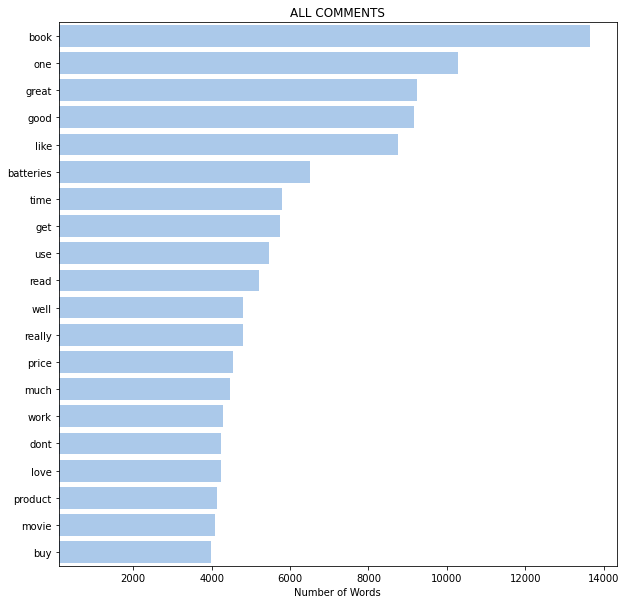

In [50]:
word_displayer(df=df_words_all, n=20, stat='all')

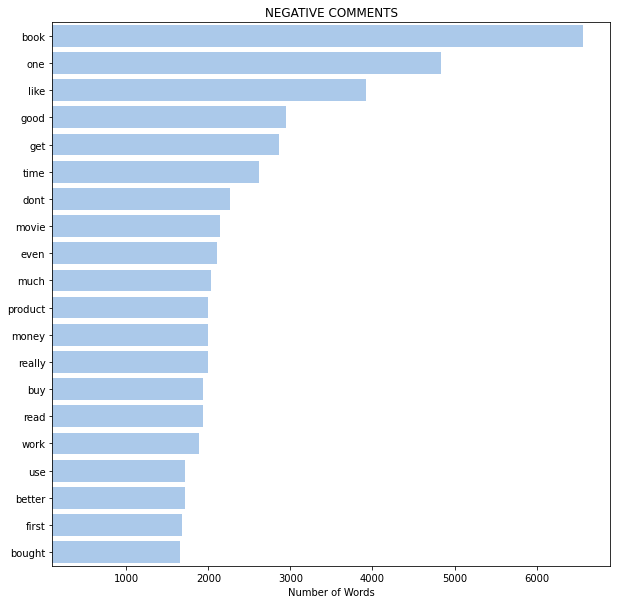

In [51]:
word_displayer(df=df_words_neg, n=20, stat='negative')

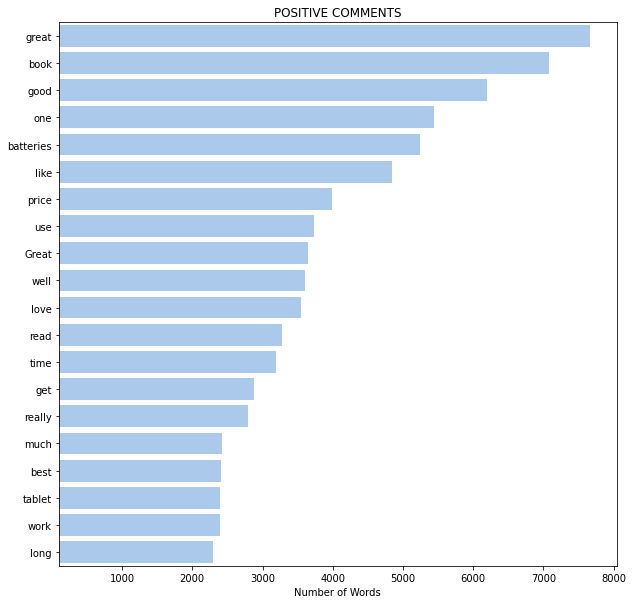

In [52]:
word_displayer(df=df_words_pos, n=20, stat='positive')

## 2. Sentiment Analysis

In [53]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

> ### I.  Logistic Regression and Naive Bayes with **CountVectorizer**

>> i. Building Pipeline



In [54]:
!wget -q https://raw.githubusercontent.com/mahavivo/vocabulary/master/lemmas/AntBNC_lemmas_ver_001.txt
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, NaiveBayes

In [73]:
%%time

document_assembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

sentence = SentenceDetector()\
      .setInputCols("document")\
      .setOutputCol("sentence")

tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

normalizer = Normalizer()\
      .setInputCols(["token"])\
      .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)


stemmer = Stemmer()\
      .setInputCols(["cleanTokens"])\
      .setOutputCol("stem")

finisher = Finisher()\
      .setInputCols(["stem"])\
      .setOutputCols(["token_features"])\
      .setOutputAsArray(True)\
      .setCleanAnnotations(False)

label_strIdx = StringIndexer(inputCol='label', outputCol='target')
logReg = LogisticRegression(maxIter=5, regParam=0.01)
naiveBayes = NaiveBayes(smoothing=5)
countVectors = CountVectorizer(inputCol="token_features", outputCol="features", vocabSize=10000, minDF=5)


CPU times: user 23.8 ms, sys: 5.15 ms, total: 28.9 ms
Wall time: 89.2 ms


>> ii. Forming Pipelines

In [74]:
# Pipeline for Logistic Regression with CountVectorizer
nlp_pipeline_cv_lr = Pipeline(
    stages=[document_assembler,
            sentence,
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            countVectors,
            logReg
            ])

# Pipeline for Naive Bayes with CountVectorizer
nlp_pipeline_cv_nb = Pipeline(
    stages=[document_assembler,
            sentence,
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            countVectors,
            naiveBayes
            ])


>> iii. Logistic Regression with CountVectorizer

>>> a. Applying LogReg

In [57]:
modelLR = nlp_pipeline_cv_lr.fit(df_train)
pred_lr = modelLR.transform(df_test)
pred_lr = pred_lr.withColumn('label', pred_lr.label.cast(IntegerType()))
pred_lr.filter(pred_lr['prediction'] == 0)\
    .select("text","probability","label","prediction")\
    .orderBy("probability", ascending=False)\
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|,""YAWN!!!!: Britney Spears...|[0.9999994581946672,5.41805...|    0|       0.0|
|,""A short story gone bad: ...|[0.9999991291536751,8.70846...|    0|       0.0|
|,""Warranty is a scam: 3 ou...|[0.999999049021483,9.509785...|    0|       0.0|
|,""script full of silliness...|[0.9999988072700032,1.19272...|    0|       0.0|
|,""One of the worst movies ...|[0.9999986815536667,1.31844...|    0|       0.0|
|,""INCREDIBLY BORING! Dull,...|[0.9999984542080427,1.54579...|    0|       0.0|
|,""What a pile of rubbish: ...|[0.9999970628947048,2.93710...|    0|       0.0|
|,""Beware: My experience wi...|[0.9999968395463019,3.16045...|    0|       0.0|
|,THE WORST TENT MADE DO NOT...|[0.9999963966212103,3.60337...|    0|       0.0|
|,""Absolute junk: I'm a rif

>>> b. Model Performance

In [58]:
# Converting pred_lr to pandas data frame in order to using sklearn metrics library
df_lr = pred_lr.select('text','label','prediction').toPandas()
print(classification_report(df_lr.label, df_lr.prediction))
print(accuracy_score(df_lr.label, df_lr.prediction))

# Evaluation within the Spark Universe is also possible (for scaling issues)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol="prediction")
evaluator.evaluate(pred_lr)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      5884
           1       0.81      0.90      0.85      5819

    accuracy                           0.84     11703
   macro avg       0.85      0.84      0.84     11703
weighted avg       0.85      0.84      0.84     11703

0.8438007348543108


0.8432768644749363


>> iv. Naive Bayes with CountVectorizer

>>> a. Applying Naive Bayes

In [75]:
modelNB = nlp_pipeline_cv_nb.fit(df_train)
pred_nb = modelNB.transform(df_test)
pred_nb = pred_nb.withColumn('label', pred_nb.label.cast(IntegerType()))
pred_nb.filter(pred_nb['prediction'] == 0)\
    .select("text","probability","label","prediction")\
    .orderBy("probability", ascending=False)\
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|,""A total waste of money: ...|  [1.0,1.3505219572305778E-17]|    0|       0.0|
|,""One of the worst movies ...|[0.9999999999999998,1.54118...|    0|       0.0|
|,""I wish I could give this...|[0.9999999999999984,1.58218...|    0|       0.0|
|,""Warranty is a scam: 3 ou...|[0.9999999999999982,1.66651...|    0|       0.0|
|,""Barely acceptable: I've ...|[0.9999999999999971,2.89542...|    0|       0.0|
|,""INCREDIBLY BORING! Dull,...|[0.9999999999999967,3.34011...|    0|       0.0|
|,""Horrible Support - Can't...|[0.9999999999999958,4.12120...|    0|       0.0|
|,""Horrible software, could...|[0.9999999999999953,4.63413...|    0|       0.0|
|,""Unfortunate errors in pr...|[0.9999999999999876,1.24826...|    0|       0.0|
|,""Works for a month before

>>> b. Model Performance

In [76]:
# Converting pred_nb to pandas data frame in order to using sklearn metrics library
df_nb = pred_nb.select('text','label','prediction').toPandas()
print(classification_report(df_nb.label, df_nb.prediction))
print(accuracy_score(df_nb.label, df_nb.prediction))

# Evaluation within the Spark Universe is also possible (for scaling issues)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol="prediction")
evaluator.evaluate(pred_nb)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5884
           1       0.85      0.83      0.84      5819

    accuracy                           0.84     11703
   macro avg       0.84      0.84      0.84     11703
weighted avg       0.84      0.84      0.84     11703

0.8430317012731778


0.8429951449233859

> ### II.  **TFIDF** Logistic Regression and Naive Bayes

>> i. Building Pipeline



In [61]:
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, NaiveBayes

In [62]:
%%time
document_assembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

sentence = SentenceDetector()\
      .setInputCols("document")\
      .setOutputCol("sentence")

tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

normalizer = Normalizer()\
      .setInputCols(["token"])\
      .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)


stemmer = Stemmer()\
      .setInputCols(["cleanTokens"])\
      .setOutputCol("stem")

finisher = Finisher()\
      .setInputCols(["stem"])\
      .setOutputCols(["token_features"])\
      .setOutputAsArray(True)\
      .setCleanAnnotations(False)

hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
label_strIdx = StringIndexer(inputCol='label', outputCol='target')
logReg = LogisticRegression(maxIter=5, regParam=0.01)
naiveBayes = NaiveBayes(smoothing=5)

CPU times: user 33.7 ms, sys: 10.8 ms, total: 44.5 ms
Wall time: 121 ms


>> ii. Forming Pipelines

In [63]:
# Pipeline for Logistic Regression with TFIDF
nlp_pipeline_tf_lr = Pipeline(
    stages=[document_assembler,
            sentence,
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            hashingTF,
            idf,
            logReg
            ])

# Pipeline for Naive Bayes with TFIDF
nlp_pipeline_tf_nb = Pipeline(
    stages=[document_assembler,
            sentence,
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            hashingTF,
            idf,
            naiveBayes
            ])


>> iii. Logistic Regression with TFIDF

>>> a. Applying LogReg

In [64]:
modelLR = nlp_pipeline_tf_lr.fit(df_train)
pred_tf_lr = modelLR.transform(df_test)
pred_tf_lr = pred_tf_lr.withColumn('label', pred_tf_lr.label.cast(IntegerType()))
pred_tf_lr.filter(pred_tf_lr['prediction'] == 0)\
    .select("text","probability","label","prediction")\
    .orderBy("probability", ascending=False)\
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                          text|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|,""Utter and complete crap ...|[0.9999980012376455,1.99876...|    0|       0.0|
|,""The title of this movie ...|[0.9999962933421801,3.70665...|    0|       0.0|
|,""Doesn't anyone else see ...|[0.9999958016955256,4.19830...|    0|       0.0|
|,""oh, the disillusionment:...|[0.9999953229921044,4.67700...|    0|       0.0|
|,""One of the worst movies ...|[0.9999952303403636,4.76965...|    0|       0.0|
|,""Terrible, just terrible:...|[0.9999945194022857,5.48059...|    0|       0.0|
|,""Beware! Send your busine...|[0.9999920135486295,7.98645...|    0|       0.0|
|,""I AGREE! LACES WAY TOO S...|[0.9999906854852427,9.31451...|    0|       0.0|
|,""Agreed: Cheap is Cheap.:...|[0.9999882527780629,1.17472...|    0|       0.0|
|,THE WORST TENT MADE DO NOT

>>> b. Model Performance

In [65]:
# Converting pred_tf_lr to pandas data frame in order to using sklearn metrics library
df_tf_lr = pred_tf_lr.select('text','label','prediction').toPandas()
print(classification_report(df_tf_lr.label, df_tf_lr.prediction))
print(accuracy_score(df_tf_lr.label, df_tf_lr.prediction))

# Evaluation within the Spark Universe is also possible (for scaling issues)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol="prediction")
evaluator.evaluate(pred_tf_lr)

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      5884
           1       0.79      0.89      0.84      5819

    accuracy                           0.83     11703
   macro avg       0.83      0.83      0.82     11703
weighted avg       0.83      0.83      0.82     11703

0.8255148252584807


0.8247548494011212


>> iv. Naive Bayes with TFIDF

>>> a. Applying Naive Bayes

In [66]:
modelNB = nlp_pipeline_tf_nb.fit(df_train)
pred_tf_nb = modelNB.transform(df_test)
pred_tf_nb = pred_tf_nb.withColumn('label', pred_tf_nb.label.cast(IntegerType()))
pred_tf_nb.filter(pred_tf_nb['prediction'] == 0)\
    .select("text","probability","label","prediction")\
    .orderBy("probability", ascending=False)\
    .show(n = 10, truncate = 30)

+------------------------------+----------------------------+-----+----------+
|                          text|                 probability|label|prediction|
+------------------------------+----------------------------+-----+----------+
|,The Acting is more hideous...|[1.0,1.1064164592528292E-16]|    0|       0.0|
|,""No fluoride filtration!:...|[1.0,1.0957682819192777E-16]|    0|       0.0|
|,""card shuffler: The item ...| [1.0,1.078460050805894E-16]|    0|       0.0|
|,WHY THIS PRODUCT SUCKS: Ko...|[1.0,1.0759857499599348E-16]|    0|       0.0|
|,""disappointing, did not h...|[1.0,1.0665636808230285E-16]|    0|       0.0|
|,""*not* a fountain pen ink...|[1.0,1.0599375894345088E-16]|    0|       0.0|
|,""Terrible book, title is ...|[1.0,1.0565913971050663E-16]|    0|       0.0|
|,""Doesn't perform efficien...|[1.0,1.0425050300348107E-16]|    0|       0.0|
|,""time is too scarce to sp...|[1.0,1.0408525521045969E-16]|    0|       0.0|
|,""First MiniDV and very un...|[1.0,1.0305086916766

>>> b. Model Performance

In [67]:
# Converting pred_tf_nb to pandas data frame in order to using sklearn metrics library
df_tf_nb = pred_tf_nb.select('text','label','prediction').toPandas()
print(classification_report(df_lr.label, df_lr.prediction))
print(accuracy_score(df_lr.label, df_lr.prediction))

# Evaluation within the Spark Universe is also possible (for scaling issues)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol="prediction")
evaluator.evaluate(pred_tf_nb)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      5884
           1       0.81      0.90      0.85      5819

    accuracy                           0.84     11703
   macro avg       0.85      0.84      0.84     11703
weighted avg       0.85      0.84      0.84     11703

0.8438007348543108


0.8024785799273807

> ### III.  Universal Sentence Encoder

>> i. Building Pipeline



In [68]:
%%time

document = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("label")\
  .setMaxEpochs(11)\
  .setEnableOutputLogs(True)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
CPU times: user 1.11 s, sys: 148 ms, total: 1.26 s
Wall time: 3min 6s


>> ii. Forming Pipeline

In [69]:
use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

In [70]:
!cd ~/annotator_logs && ls -l

/bin/bash: line 0: cd: /root/annotator_logs: No such file or directory



>> iii. Universal Sentence Encoder with Deep Learning Approach

>>> a. Applying Universal Sentence Encoder with DL

In [71]:
useModel = use_clf_pipeline.fit(df_train)
pred_use = useModel.transform(df_test)
df_use = pred_use.select('text','label', 'class.result').toPandas()
df_use['result'] = df_use['result'].apply(lambda x: x[0])
df_use.head()

,text,label,result
0,",Not worth the money: Banks'book Oscilloscope ...",0,1
1,",""""I changed my mind: When I first reviewed th...",0,0
2,",""""How quickly we fail...: I was initially ent...",0,0
3,",DOA Did Not Power up out of the box: DOA prod...",0,0
4,",""""support: I ordered this nursing bra after l...",0,0


>>> b. Model Performance

In [72]:
print(classification_report(df_use.label, df_use.result))
print(accuracy_score(df_use.label, df_use.result))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5884
           1       0.86      0.87      0.87      5819

    accuracy                           0.87     11703
   macro avg       0.87      0.87      0.87     11703
weighted avg       0.87      0.87      0.87     11703

0.8652482269503546


# 3. Conclusion

Considering the wide application areas of NLP, building solid algorithms on a large scale is a powerful asset that strengthens the competence of companies in almost all business areas. From this perspective, I approached this simulation of ESPRIT's use case, keeping in touch with 3 pillars.

The first pillar could be described as "keeping up with the pace of NLP inferno". In other words, I applied modern embedding techniques like "Universal Sentence Embedding" which use pre-trained embedding algorithms powered by Deep Learning under the hood. Not to my surprise, I got the best accuracy results using "Universal Sentence Embedding". But also I needed to use resources effectively and did not used alternatives like Bert Sentence Embedding (Note that for code readability reasons, no fine tuning steps are included in this notebook). 

The second pillar is "simplicity" and this is where pipelines comes into play. I built pipelines that made my code modular, digestible and also stable. My team partners could easily apply/improve my code without any additional support, which cannot be overstated.

The third pillar is 'extending the horizon' which could be explained observing the wider possibilities and sharing these new horizons with my colleagues. To do so I attended the John Snow Labs NLP for Data Science workshop (live-online) and tried to apply these new visions in my case study.

There is no one best model or the only possible solution to every business problem. That's why I look forward to your insight. I want to express my appreciation to have such an opportunity. 

Thank you for your time and see you all tomorrow!

